# Testing av koden

For å se om alt fungerer som det skal, har vi implementert tester av forskjellige lag og funksjoner.
Vi bruker blandt annet den innebgydde funksjonen assert som sjekker om påstanden til venstre er korrekt, dersom den ikke er det returnerer den AssertionError med kommentaren til høyre for komma. 

For eksempel har vi:
assert X.shape == (b,m,n), f"X.shape={X.shape}, expected {(b,m,n)}"
Dersom X har dimensjon (b,m,n) vil koden kjøre normalt, dersom den ikke har det vil den returnere AssertionError og "X.shape = {X.shape}, expected {(b,m,n)}"

In [22]:
from layers import *
from neural_network import NeuralNetwork
import numpy as np
from tqdm import trange
from typing import Any
from optimizer import Adam
from utils import *
from data_generators import get_train_test_sorting
from training import make_model, training_sorting, training_addition
import matplotlib.pyplot as plt

In [24]:
# We choose some arbitrary values for the dimensions
b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20

# Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

# initialize the layers
feed_forward = FeedForward(d,p)
self_attention = SelfAttention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m, True)
softmax = Softmax()
transformerblock = TransformerBlock(d,k,p)

# a manual forward pass
X = jit_onehot(x, m)  # (b, m, n)
z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = self_attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 

# Check the shapes
assert X.shape == (b,m,n), f'X.shape={X.shape}, expected {(b,m,n)}'
assert z0.shape == (b,d,n), f'z0.shape={z0.shape}, expected {(b,d,n)}'
assert z1.shape == (b,d,n), f'z1.shape={z1.shape}, expected {(b,d,n)}'
assert z2.shape == (b,d,n), f'z2.shape={z2.shape}, expected {(b,d,n)}'
assert z3.shape == (b,m,n), f'z3.shape={z3.shape}, expected {(b,m,n)}'
assert Z.shape == (b,m,n), f'Z.shape={Z.shape}, expected {(b,m,n)}'

#is X one-hot?
assert X.sum() == b*n, f'X.sum()={X.sum()}, expected {b*n}'

assert np.allclose(Z.sum(axis=1), 1), f'Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}'
assert np.abs(Z.sum() - b*n) < 1e-5, f'Z.sum()={Z.sum()}, expected {b*n}'
assert np.all(Z>=0), f'Z={Z}, expected all entries to be non-negative'


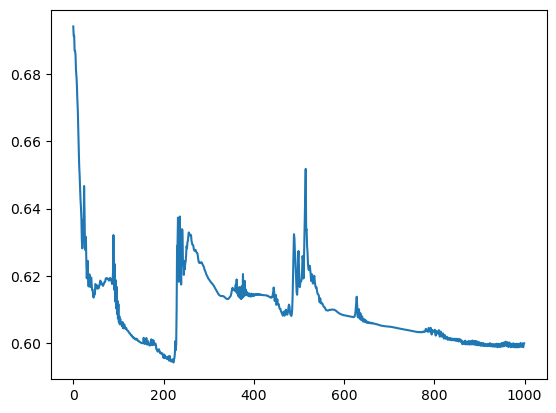

In [25]:

def get_test_data():
   data_set = get_train_test_sorting(length=5, num_ints=2, samples_per_batch=250, n_batches_train=10, n_batches_test=2)
   train_set = list(zip(data_set['x_train'], data_set['y_train']))
   return train_set


def test_forward_shape():
   model = make_model()
   train_set = get_test_data()
   batch_x = onehot(train_set[0][0], 2)
   out = model.forward(batch_x)
   assert out.shape == (250, 2, 9)


def test_backward():
   model = make_model()
   grad_loss = np.random.randn(250)
   train_set = get_test_data()
   batch_x = jit_onehot(train_set[0][0], 2)
   Y_pred = model.forward(batch_x)
   loss_function = CrossEntropy()
   y_true = train_set[1][0]
   Y_true = jit_onehot(y_true, 2)
   loss_function.forward(Y_pred, Y_true)
   grad_loss = loss_function.backward()
   model.backward(grad_loss)
  

def test_adam():
   np.seterr(all='raise')

   # Initialize model and optimizer
   model = make_model()
   optimizer = Adam()
   # Overfit on a single example

   # Get all training data
   train_set = get_test_data()

   loss_function = CrossEntropy()

   m = 2

   # First input value from training set
   input = train_set[0][0]
   output = train_set[0][1]
   batch_x = jit_onehot(input, m)

   iter = np.arange(1000)
   loss_arr = np.zeros(1000)

   for i in range(1000):
      Y_hat = model.forward(batch_x)
      # y_hat: (b, m, n)
      y_hat = np.argmax(Y_hat, axis=1)[:,-5:]
      y_true = train_set[1][0]
      Y_true = jit_onehot(y_true, m)
      
      correct = y_hat == output
      accuracy = np.mean(correct)

      loss_value = loss_function.forward(Y_hat, Y_true).mean()

      # dLdY: (b, m, n)
      grad_loss = loss_function.backward()
      model.backward(grad_loss)
      model.step_gd(optimizer)

      #print(f'{accuracy=:.5f}, {loss_value=:.5f}')
      loss_arr[i] = loss_value
   
      # check if loss is non-negative
      assert loss_value >= 0, f"L={loss_value}, expected L>=0"
      assert grad_loss.shape == Y_hat.shape, f"grad_Z.shape={grad_loss.shape}, expected {Y_hat.shape}"

      ideal_loss_value = loss_function.forward(Y_true, Y_true).mean()
      assert ideal_loss_value < 1e-5, f"L={ideal_loss_value}, expected L<1e-5"

   plt.plot(iter, loss_arr)
   plt.show()

if __name__ == '__main__':
   test_forward_shape()
   test_backward()
   test_adam()